In [1]:
import sys
import jax
import jax.numpy as jnp
from flax import nnx
import optax
from IPython.display import clear_output
import matplotlib.pyplot as plt

sys.path.append('/workspace')
from nanochat.jax.gpt import GPT, GPTJaxConfig

In [2]:
config = GPTJaxConfig(
    sequence_len=128,
    vocab_size=64,
    n_layer=1,
    n_head=6,
    n_kv_head=6,
    n_embd=16*6,
    dtype=jnp.bfloat16)

In [3]:
gpt = GPT(config, rngs=nnx.Rngs(0))

INFO:2026-02-02 22:44:59,846:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2026-02-02 22:44:59,846 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [4]:
nnx.display(gpt)

In [5]:
tokens = jnp.array([
    [1, 2, 3, 4, -1],
    [5, 6, 7, 8, -1],
])
gpt(tokens[:, :4], tokens[:, 1:])

Array(3.359424, dtype=float32)

In [6]:
logits = gpt(tokens[:, :4])
targets = tokens[:, 1:]
targets = targets.reshape(-1)
optax.softmax_cross_entropy_with_integer_labels(
    logits.reshape(-1, logits.shape[-1]),
    targets, where=targets > -1)

Array([5.5066986, 2.9597497, 4.6052756, 0.       , 3.1805847, 5.437855 ,
       5.1852293, 0.       ], dtype=float32)

In [7]:
def loss_fn(model: GPT, batch: jax.Array):
    return model(batch[:, :-1], batch[:, 1:])

@nnx.jit
def train_step(model: GPT, optimizer: nnx.Optimizer, metrics: nnx.Metric, rngs: nnx.Rngs, batch: jax.Array):
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
  loss, grads = grad_fn(model, batch)
  metrics.update(loss=loss)
  optimizer.update(model, grads)

In [8]:
grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
loss, grads = grad_fn(gpt, tokens)
loss

Array(3.359424, dtype=float32)

In [9]:
nnx.display(jax.tree.map(lambda x: jnp.mean(jnp.abs(x)), grads))

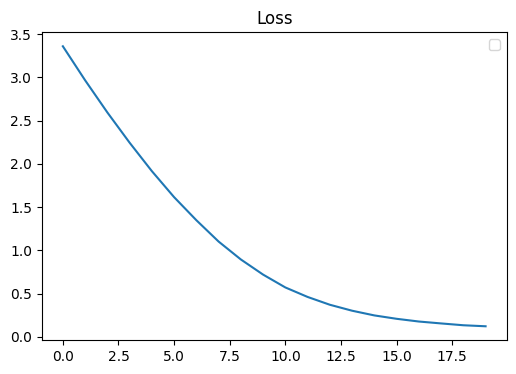

In [10]:
scalar_lr = 0.0003
optimizer = nnx.Optimizer(gpt, optax.adamw(learning_rate=scalar_lr), wrt=nnx.Param)
metrics = nnx.metrics.Average('loss')
rngs = nnx.Rngs(0)
gpt.train()
loss = []
for _ in range(20):
    train_step(gpt, optimizer, metrics, rngs, tokens)
    loss.append(metrics.compute().item())
    metrics.reset()

    clear_output(wait=True)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    ax.set_title('Loss')
    ax.plot(loss)
    ax.legend()
    plt.show()